# 🖖 Import

In [1]:
import copy, math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from scipy.spatial import distance
from scipy import stats


# 🛰️ Load Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [3]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# 🚀 Data Exploration & Cleaning

<p>
    <img style="float:right; max-height:200px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Philip_K_Dick_in_early_1960s_%28photo_by_Arthur_Knight%29_%28cropped%29.jpg/1200px-Philip_K_Dick_in_early_1960s_%28photo_by_Arthur_Knight%29_%28cropped%29.jpg">
</p>

<figure>
    <blockquote>
        <p>"No structure, even an artificial one, enjoys the process of entropy. It is the ultimate fate of everything, and everything resists it."</p>
    </blockquote>
    <figcaption>— Philip K. Dick, <cite>Galactic Pot-Healer</cite></figcaption>
</figure>

Image Source: <a href="https://en.wikipedia.org/wiki/Philip_K._Dick">Wikipedia</a>

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Numerical features

In [6]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


**📝 Takeaways** 
* Wide ranges of values within the numerical features
* All numeric features except Age represent money spent on various services

We could sum those numbers up in a new feature and see who enjoyed the space travel the most.


In [7]:
billing_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_train['total_billed'] = df_train[billing_columns].sum(axis = 1)
df_test['total_billed'] = df_test[billing_columns].sum(axis = 1)

In [8]:
df_train['total_billed'].describe()

count     8693.000000
mean      1440.866329
std       2803.045694
min          0.000000
25%          0.000000
50%        716.000000
75%       1441.000000
max      35987.000000
Name: total_billed, dtype: float64

**📝 Takeaways** 
* The mean is very low compared to the max, which means there are outliers
* Some people spent no money

Furthermore, we can get the group from the PassengerId, as per data doc: <br>

<li><code>PassengerId</code> - A unique Id for each passenger. Each Id takes the form <code>gggg_pp</code> where <code>gggg</code> indicates a group the passenger is travelling with and <code>pp</code> is their number within the group. People in a group are often family members, but not always.</li>


In [9]:
#Test
groups = df_test['PassengerId'].str.split('_', expand = True)[0]
groups_map = pd.value_counts(groups)
df_test['group'] = groups
df_test['n_in_group'] = groups.map(groups_map)

In [10]:
#train
groups = df_train['PassengerId'].str.split('_', expand = True)[0]
groups_map = pd.value_counts(groups)
df_train['group'] = groups
df_train['n_in_group'] = groups.map(groups_map)
groups_map

4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: 0, Length: 6217, dtype: int64

In [11]:
pd.value_counts(df_test['group'])

6332    8
6499    8
6986    8
8543    8
1072    8
       ..
3532    1
3538    1
3541    1
3545    1
9277    1
Name: group, Length: 3063, dtype: int64

In [12]:
df_train['n_in_group'].describe()

count    8693.000000
mean        2.035546
std         1.596347
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         8.000000
Name: n_in_group, dtype: float64

**📝 Takeaways** 
* Later we will evaluate, if these features are useable.

## Categorical features

In [13]:
df_train.select_dtypes(include = 'object').nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
group          6217
dtype: int64

**📝 Takeaways**<br>
* PassengerId is the uniue identifier and not relevant for regression, we already extracted the group

Let's look at the categorical features in detail.

### Homeplanet

In [14]:
pd.value_counts(df_train['HomePlanet'])

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

**📝 Takeaways**<br>
* Most people come from Earth 🌎
* The other options are Mars and Europa

<p><img style="float:right; margin-left:20px; padding-left:20px; max-height:150px" src="https://www.nasa.gov/sites/default/files/styles/full_width_feature/public/thumbnails/image/europa_0.jpg"></p>
    <p style="text-align:justify;">
        While life on Mars seems closer than ever, Europa is not actually a planet. It is a moon of Jupiter. How feasible is life on Europa today? It turns out, it's not science fiction. NASA has been interested in the possibility of life on Europa, since <a href='https://europa.nasa.gov/why-europa/ingredients-for-life/'>it has all the basic ingredients for life</a>. It even subject to scientific speculation for <a href='https://en.wikipedia.org/wiki/Colonization_of_Europa'>future human colonization</a>.
    </p>
Image Source: <a href="https://www.nasa.gov/image-feature/europa-by-the-numbers">NASA</a>

### CyroSleep

In [15]:
pd.value_counts(df_train['CryoSleep'])

False    5439
True     3037
Name: CryoSleep, dtype: int64

**📝 Takeaways**<br>
* More people chose to not use CyroSleep

Cyonics are a popular trope in science fiction, espacially for travel purposes. Often to rationalize intergallactic travel. While it may seem futuristic, cyrotherapy is already a business model in todays world. It is used to relief pain after surgery among other things. Even cyrosleep is not only a concept of the far future. There are entities like [Space Works Enterprises](https://www.spaceworks.aero/engineering/) or the [Cryonics Institue](https://www.cryonics.org/) that actively research in this area. Especially among [wealthy people](https://www.tatler.com/article/super-rich-freezing-bodies-for-the-future), freezing the body after death in hope of future doctors reversing it, is becoming popular.


### Cabin

In [16]:
pd.value_counts(df_train['Cabin'])

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

**📝 Takeaways**<br>
* Cabin is a structured string, that holds multiple informations
* The most crammed room had 8 passengers. Maybe those guys in cyrosleep?

From the data documentation, we know that: <br>

<li><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form <code>deck/num/side</code>, where <code>side</code> can be either <code>P</code> for <em>Port</em> or <code>S</code> for <em>Starboard</em>.</li><br>
Since the deck and side represent most likely spacial location within the ship of the passengers, it could be interesting to extract these values into their own features.


In [17]:
#Train
df_train[['Cabin_deck','Cabin_num', 'Cabin_side']] = df_train['Cabin'].str.split('/', expand=True)
df_train['Cabin_side'] = df_train['Cabin_side'].map({'P':'Port', 'S':'Starboard'})
df_train['Cabin_num'] = df_train['Cabin_num'].astype(float)

In [18]:
#Test
df_test[['Cabin_deck','Cabin_num', 'Cabin_side']] = df_test['Cabin'].str.split('/', expand=True)
df_test['Cabin_side'] = df_test['Cabin_side'].map({'P':'Port', 'S':'Starboard'})

In [19]:
pd.value_counts(df_train['Cabin_deck'])

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin_deck, dtype: int64

In [20]:
df_train['Cabin_num'].describe()

count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: Cabin_num, dtype: float64

In [21]:
pd.value_counts(df_train['Cabin_side'])

Starboard    4288
Port         4206
Name: Cabin_side, dtype: int64

**📝 Takeaways**<br>
* F and G are by far the most common decks.
* There is no structure in num, it should be discarded in Pre Processing
* Starboard and Port side are about equally distributed

### Destination

In [22]:
pd.value_counts(df_train['Destination'])

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

**📝 Takeaways**<br>
* There are 3 destination stops
* PSO J318.5-22 is the least popular

<p><img style="float:right; margin-left:20px; padding-left:20px; max-height:150px" src="https://upload.wikimedia.org/wikipedia/commons/3/38/TRAPPIST-1e_artist_impression_2018.png"></p>
    <p style="text-align:justify;">TRAPPIST-1e and 55 Cancri e are famous <a href='https://en.wikipedia.org/wiki/Exoplanet'>exoplanets</a>, planets similar to earth. On the other hand, PSO J318.5-22 is a <a href='https://en.wikipedia.org/wiki/Rogue_planet'>rogue planet</a>. This means, the planet is not gravitationally bound to a star. They have been ejected from their host planetary system or have never been part of one. This explains the low destination rate, however still some passengers empathize with this planet and try to visit.</p>
Image Source: <a href="https://en.wikipedia.org/wiki/TRAPPIST-1e">Wikipedia: TRAPPIST-1e</a>

### VIP

In [23]:
pd.value_counts(df_train['VIP'])

False    8291
True      199
Name: VIP, dtype: int64

**📝 Takeaways**<br>
* VIP is a bool
* Only just under 200 people have VIP status.

### Name

In [24]:
pd.value_counts(df_train['Name'])

Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64

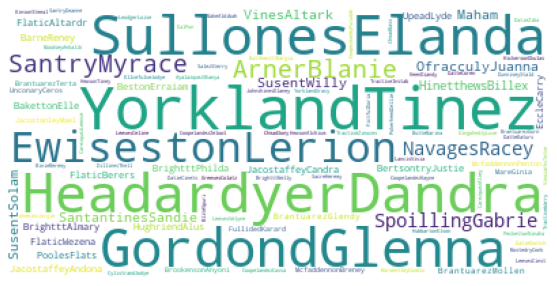

In [25]:
wordcloud = WordCloud(background_color = "white", relative_scaling=.5).generate(df_train['Name'].str.cat())
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [26]:
pd.value_counts(df_train['Name'].str.split(' ').str.len())

2.0    8493
Name: Name, dtype: int64

**📝 Takeaways**<br>
* There are full duplicated names, we need to check for duplicate rows
* The future has interesting names such as Sus 👨‍🚀
* Each Name entry contains two words exactly. From the head, we supose that the first word is the first name

If we assume that the onomastics of family names are similar to our world, we could calculate the number of people that might be related.

In [27]:
#Test
family_names = df_test['Name'].str.split(' ', expand=True)[1]
family_names_map = pd.value_counts(family_names)
df_test['n_related'] = family_names.map(family_names_map)

In [28]:
#Train
family_names = df_train['Name'].str.split(' ', expand=True)[1]
family_names_map = pd.value_counts(family_names)
df_train['n_related'] = family_names.map(family_names_map)

print(family_names_map.head())

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
Name: 1, dtype: int64


In [29]:
pd.value_counts(df_test['n_related'])

2.0     950
3.0     792
4.0     696
1.0     629
5.0     430
6.0     270
7.0     168
8.0     136
9.0      54
10.0     20
14.0     14
13.0     13
11.0     11
Name: n_related, dtype: int64

**📝 Takeaways**<br>
* There are many people with a lot of related people on board
* This might be, because only the name is the same but there is no relation

We can evaluate this feature later and decide, if it is usable or should be removed in Pre Processing. <br><br>

In [30]:
pd.value_counts(df_train['group'])

4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: group, Length: 6217, dtype: int64

In [31]:
df_train['group'].unique

<bound method Series.unique of 0       0001
1       0002
2       0003
3       0003
4       0004
        ... 
8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: group, Length: 8693, dtype: object>

**📝 Takeaways**<br>
* There are a lot of different groups

We can evaluate this feature later and decide, if it is usable or should be removed in Pre Processing. <br><br>

Let's check next for duplicate values now.

In [32]:
df_train.drop(['PassengerId'], axis = 1).duplicated().any()

False

In [33]:
has_duplicates = pd.value_counts(df_train['Name']) > 1
name_duplicates = has_duplicates[has_duplicates].index
df_train[df_train['Name'].isin(name_duplicates)].sort_values(by=['Name'])[:10]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,total_billed,group,n_in_group,Cabin_deck,Cabin_num,Cabin_side,n_related
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,...,6027.0,Alraium Disivering,False,6527.0,7775,1,C,253.0,Port,7.0
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,...,0.0,Alraium Disivering,True,0.0,6665,4,B,222.0,Port,7.0
476,0512_02,Europa,True,D/18/S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,...,0.0,Ankalik Nateansive,True,0.0,0512,2,D,18.0,Starboard,4.0
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,...,1464.0,Ankalik Nateansive,True,10624.0,3176,1,E,196.0,Port,4.0
8488,9071_01,Earth,False,F/1855/P,55 Cancri e,22.0,False,0.0,0.0,1072.0,...,3.0,Anton Woody,False,1121.0,9071,1,F,1855.0,Port,10.0
2991,3236_03,Earth,False,E/200/P,TRAPPIST-1e,18.0,False,0.0,30.0,0.0,...,5.0,Anton Woody,False,791.0,3236,3,E,200.0,Port,10.0
2559,2746_01,Mars,False,F/569/P,TRAPPIST-1e,52.0,False,758.0,0.0,356.0,...,0.0,Apix Wala,False,1119.0,2746,1,F,569.0,Port,7.0
4108,4387_01,Mars,False,F/902/P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,...,0.0,Apix Wala,False,651.0,4387,1,F,902.0,Port,7.0
7871,8398_01,Europa,True,B/329/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,0.0,Asch Stradick,True,0.0,8398,2,B,329.0,Starboard,3.0
6086,6432_01,Europa,False,D/202/P,55 Cancri e,55.0,False,114.0,222.0,0.0,...,2919.0,Asch Stradick,False,5830.0,6432,1,D,202.0,Port,3.0


**📝 Takeaways**<br>
* There are no duplicated rows
* The duplicated names seem to have the same HomePlanet, but are otherwise distinct

These people probably just happen to have the same name. However, there might be an anomaly here...

# 🔭 Data Visualization

<p>
    <img style="float:right; max-height:200px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Isaac.Asimov01.jpg/800px-Isaac.Asimov01.jpg">
</p>

<figure>
    <blockquote cite="https://en.wikipedia.org/wiki/Galactic_Pot-Healer">
        <p>"What makes it so hard to organize the environment sensibly is that everything we touch is hooked up to everything else."</p>
    </blockquote>
    <figcaption>—  Isaac Asimov, <cite> Isaac Asimov’s Book of Science and Nature Quotations</cite></figcaption>
</figure>


Image Source: <a href="https://en.wikipedia.org/wiki/Isaac_Asimov">Wikipedia</a>

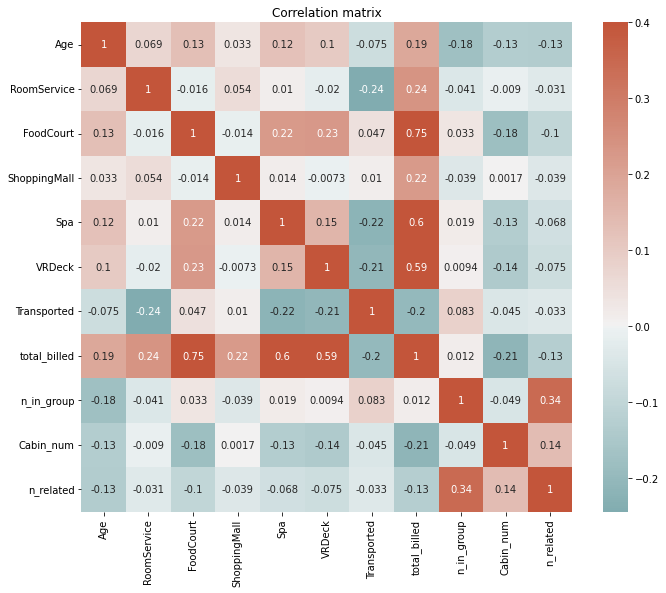

In [34]:
corr = df_train.corr()
plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(corr ,annot = True, cmap=cmap, vmax=.4, center=0).set_title('Correlation matrix');

**📝 Takeaways**<br>
* There is generally a low correlation
* The best correlation for Transported is FoodCount
* As expected, there is no connection between cabin_num and Transported

We will have to work with the categorical data.


## Numeric Features

### Age

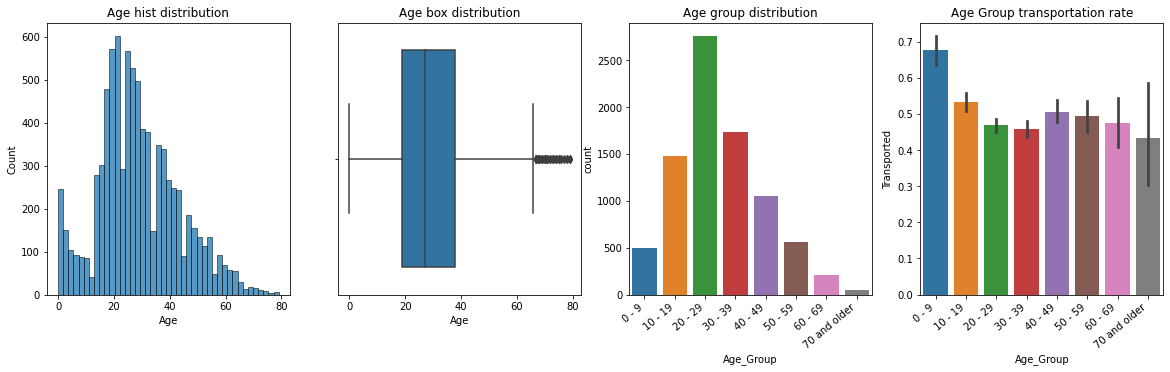

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(ax = axes[0], x = df_train["Age"]).set_title('Age hist distribution')
sns.boxplot(ax = axes[1], x = df_train['Age']).set_title('Age box distribution')

#Define age limit for groups and their labels
age_groups_thresholds = [0, 9, 19, 29, 39, 49, 59, 69, np.inf]
age_groups = ["0 - 9", "10 - 19", "20 - 29", "30 - 39", "40 - 49", "50 - 59", "60 - 69", "70 and older"]

#Cut Age Series by thresholds and load into new feature
df_train["Age_Group"] = pd.cut(df_train['Age'], age_groups_thresholds, labels=age_groups)
sns.countplot(ax = axes[2], x=df_train["Age_Group"]).set_title('Age group distribution')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 40, ha="right")
sns.barplot(ax = axes[3], data = df_train, x = "Age_Group", y = "Transported").set_title('Age Group transportation rate')
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation = 40, ha="right");

**📝 Takeaways**<br>
* Most passengers were fairly young
* The most common age group was 20 - 29
* Children had the highest rate of transportation, otherwiser it is pretty balanced


### Total billed

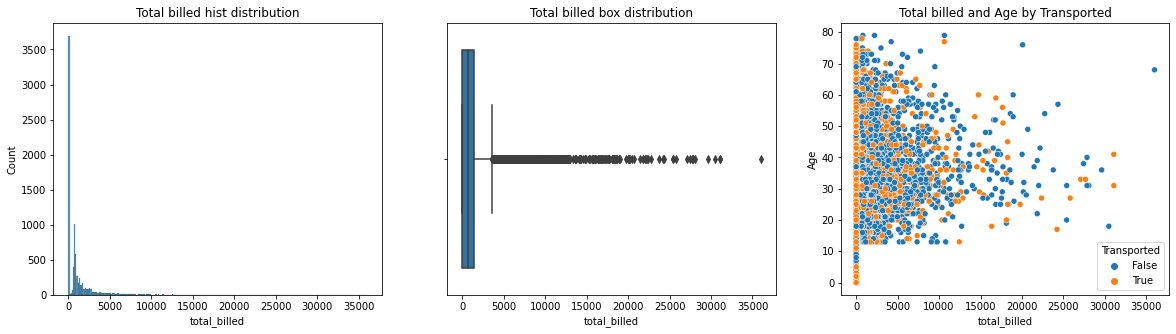

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(ax = axes[0], x = df_train["total_billed"]).set_title('Total billed hist distribution')
sns.boxplot(ax = axes[1], x = df_train['total_billed']).set_title('Total billed box distribution')
sns.scatterplot(ax = axes[2], data = df_train, x='total_billed', y='Age', hue = 'Transported').set_title('Total billed and Age by Transported');

**📝 Takeaways**<br>
* As seen in the Data Exploration, most people don't use the Services
* However, there are some far outliers
* No clear connection to Transported can be seen

### n Related

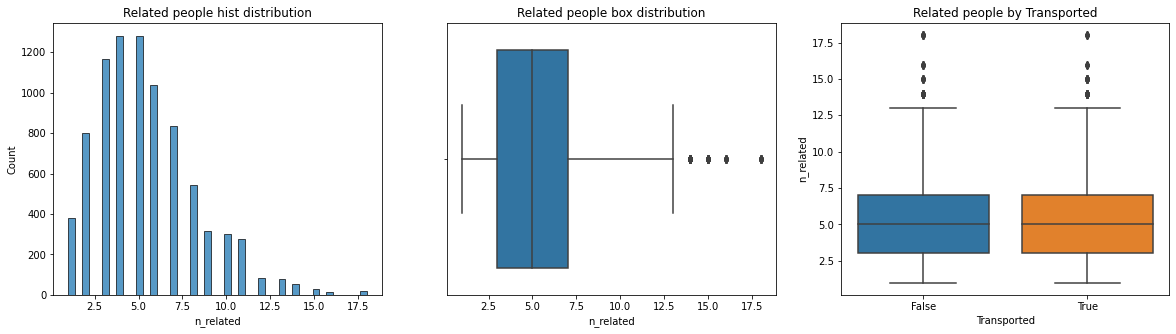

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(ax = axes[0], x = df_train["n_related"]).set_title('Related people hist distribution')
sns.boxplot(ax = axes[1], x = df_train['n_related']).set_title('Related people box distribution')
sns.boxplot(ax = axes[2], data = df_train, x="Transported", y="n_related").set_title('Related people by Transported');

**📝 Takeaways**<br>
* Number of related people on board is normal distributed around 5 with a positive skew
* It holds no information concerning Transported

### n in Group

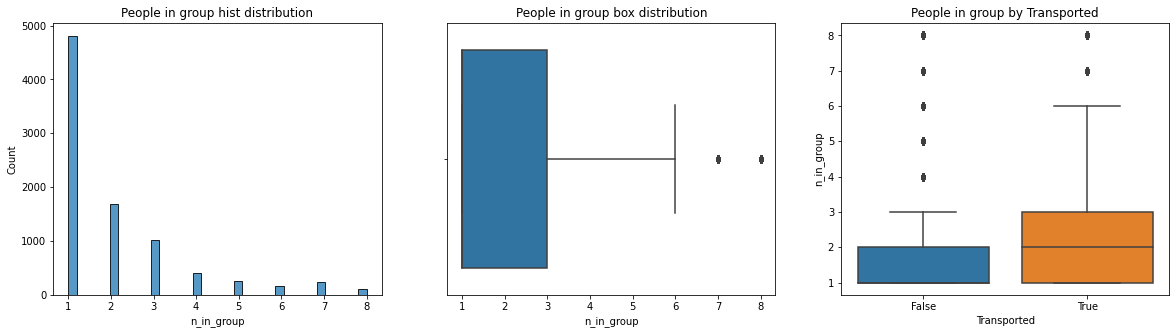

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(ax = axes[0], x = df_train["n_in_group"]).set_title('People in group hist distribution')
sns.boxplot(ax = axes[1], x = df_train['n_in_group']).set_title('People in group box distribution')
sns.boxplot(ax = axes[2], data = df_train, x="Transported", y="n_in_group").set_title('People in group by Transported');

**📝 Takeaways**<br>
* Most people are in small groups
* There are a few outliers
* There seems to be a correlation to Transported

We can use this feature in the model.

## Categorical data

### HomePlanet

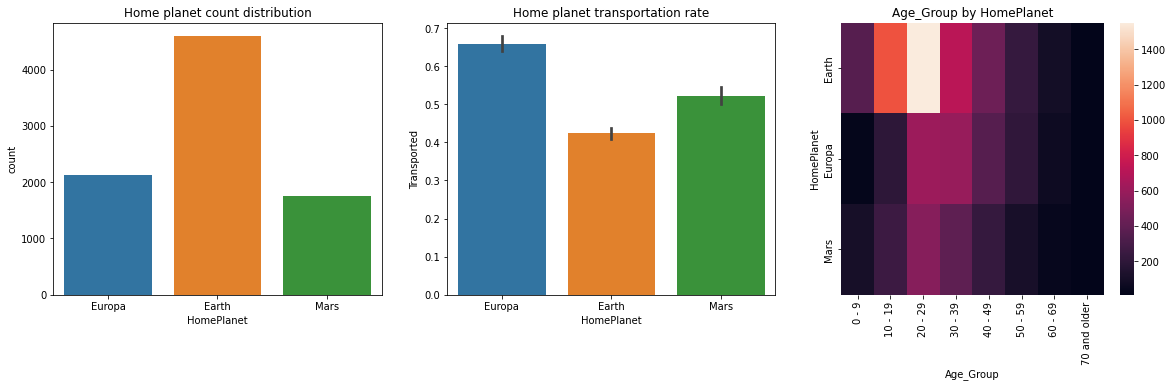

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(ax = axes[0], x = df_train['HomePlanet']).set_title('Home planet count distribution')
sns.barplot(ax = axes[1], data = df_train, x = "HomePlanet", y = "Transported").set_title('Home planet transportation rate')

crosstable_joined_homeplanet = pd.crosstab(df_train['HomePlanet'], df_train['Age_Group'])
sns.heatmap(ax = axes[2], data = crosstable_joined_homeplanet).set_title('Age_Group by HomePlanet');

**📝 Takeaways**<br>
* Earth had the lowest transportation rate, while people from Europa were transported the most
* There seems to be no connection between home planet and age

### CyroSleep

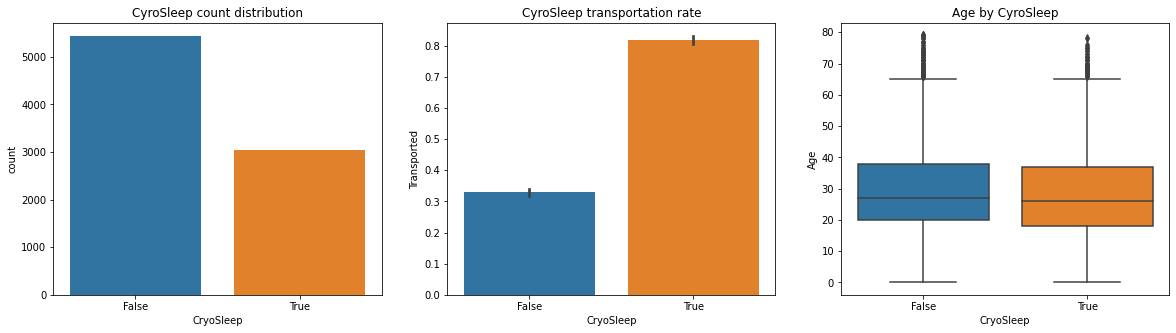

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(ax = axes[0], x = df_train['CryoSleep']).set_title('CyroSleep count distribution')
sns.barplot(ax = axes[1], data = df_train, x = "CryoSleep", y = "Transported").set_title('CyroSleep transportation rate')
sns.boxplot(ax = axes[2], data = df_train, x="CryoSleep", y="Age").set_title('Age by CyroSleep');

**📝 Takeaways**<br>
* People in CyroSleep had a very high rate of transportation
* Age did not determine who got the CyroSleep

### VIP

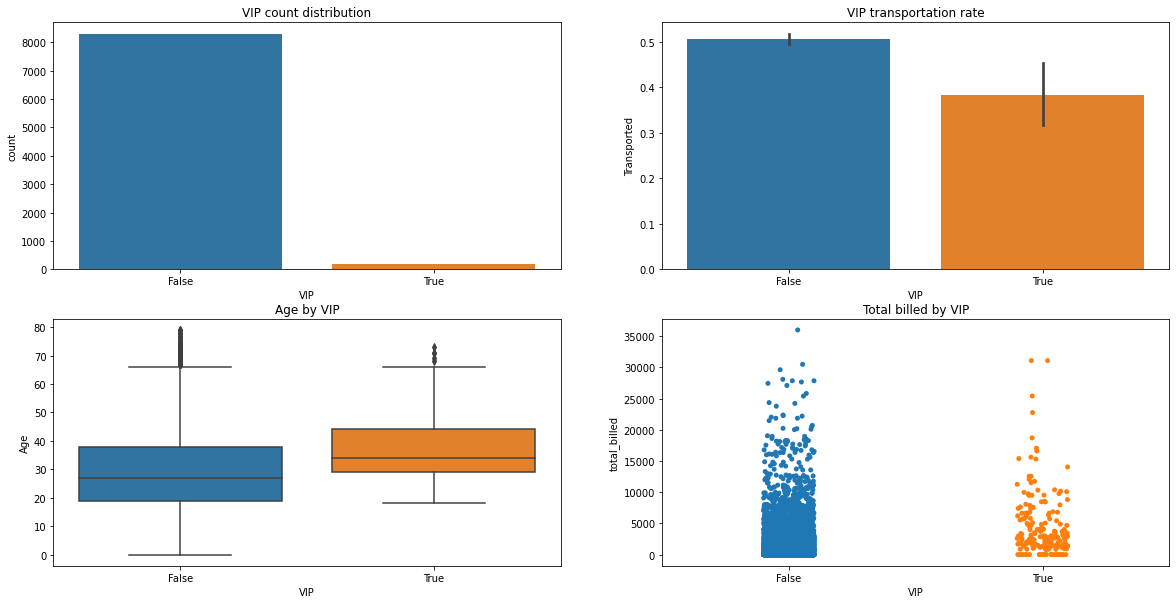

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.countplot(ax = axes[0][0], x = df_train['VIP']).set_title('VIP count distribution')
sns.barplot(ax = axes[0][1], data = df_train, x = "VIP", y = "Transported").set_title('VIP transportation rate')
sns.boxplot(ax = axes[1][0], data = df_train, x="VIP", y="Age").set_title('Age by VIP')
sns.stripplot(ax = axes[1][1], data = df_train, x="VIP", y="total_billed").set_title('Total billed by VIP');

**📝 Takeaways**<br>
* The transportation rate is about equal
* VIP tend to be older and spend more

### Cabin_deck

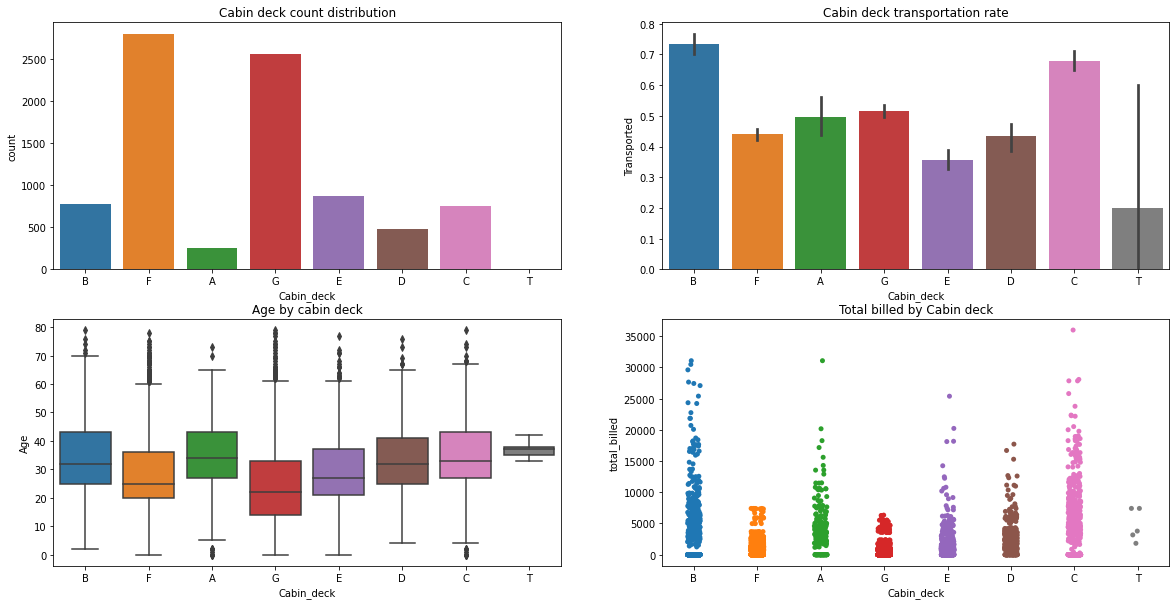

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.countplot(ax = axes[0][0], x = df_train['Cabin_deck']).set_title('Cabin deck count distribution')
sns.barplot(ax = axes[0][1], data = df_train, x = "Cabin_deck", y = "Transported").set_title('Cabin deck transportation rate')
sns.boxplot(ax = axes[1][0], data = df_train, x="Cabin_deck", y="Age").set_title('Age by cabin deck')
sns.stripplot(ax = axes[1][1], data = df_train, x="Cabin_deck", y="total_billed").set_title('Total billed by Cabin deck');

**📝 Takeaways**<br>
* Decks F and G were the most used
* Cabin B and C had the highest chance of transportation
* Cabin B and C also had the highest bills
* Age is equally distributed on decks

### Cabin_side

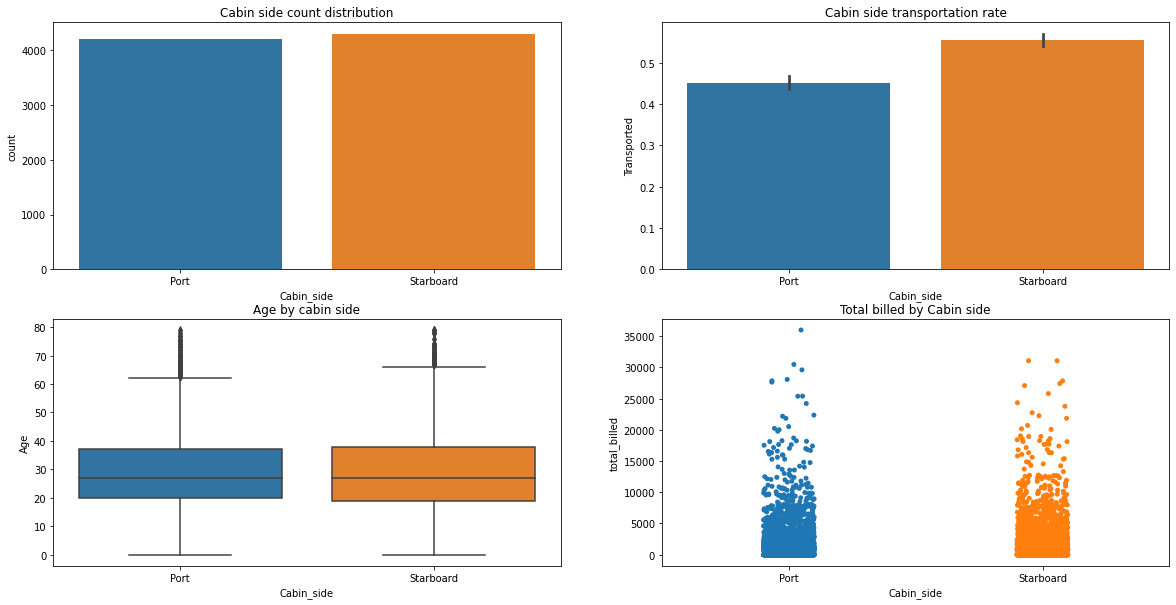

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.countplot(ax = axes[0][0], x = df_train['Cabin_side']).set_title('Cabin side count distribution')
sns.barplot(ax = axes[0][1], data = df_train, x = "Cabin_side", y = "Transported").set_title('Cabin side transportation rate')
sns.boxplot(ax = axes[1][0], data = df_train, x="Cabin_side", y="Age").set_title('Age by cabin side')
sns.stripplot(ax = axes[1][1], data = df_train, x="Cabin_side", y="total_billed").set_title('Total billed by Cabin side');

**📝 Takeaways**<br>
* Sides are equally distributed
* Starboard has a slightly higher chance of transportation
* The age was equally distributed on sides
* No clear difference between spending of sides

# 🛸 Pre Processing

<p><img style="float:right; max-height:200px" src="https://upload.wikimedia.org/wikipedia/commons/f/f2/Spock_at_console.jpg"></p>

<figure>
    <blockquote cite="https://en.wikipedia.org/wiki/Star_Trek">
        <p>"Insufficient facts always invite danger."</p>
    </blockquote>
    <figcaption>— Spock, <cite>Star Trek</cite></figcaption>
</figure>

Image Source: <a href="https://en.wikipedia.org/wiki/Spock">Wikipedia</a>

In [44]:
df_test_passengerId = df_test['PassengerId']

df_train = df_train.drop(['total_billed', 'Age_Group', 'Cabin_num', 'PassengerId', 'Cabin', 'Name'], axis = 1)
df_test = df_test.drop(['total_billed', 'Cabin_num', 'PassengerId', 'Cabin', 'Name'], axis = 1)

In [45]:
#Remove na
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", 'n_in_group', 'n_related']
imputer = SimpleImputer(strategy = 'mean' )
imputer.fit(df_train[imputer_cols])
df_train[imputer_cols] = imputer.transform(df_train[imputer_cols])
df_test[imputer_cols] = imputer.transform(df_test[imputer_cols])

standard_scaler = StandardScaler()
df_train[imputer_cols] = standard_scaler.fit_transform(df_train[imputer_cols])
df_test[imputer_cols] = standard_scaler.fit_transform(df_test[imputer_cols]);

In [46]:
s = (df_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df_train[object_cols].astype('str')))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(df_test[object_cols].astype('str')))

# One-hot encoding removed index; put it back
OH_cols_train.index = df_train.index
OH_cols_valid.index = df_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = df_train.drop(object_cols, axis=1)
num_X_valid = df_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
df_train = pd.concat([num_X_train, OH_cols_train], axis=1)
df_test = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [47]:
df_train = df_train.astype('float')
df_test = df_test.astype('float')

In [48]:
df_train.shape

(8693, 6252)

In [49]:
df_test.shape

(4277, 6251)

In [50]:
X = df_train.drop('Transported', axis=1).to_numpy()
y = df_train['Transported'].to_numpy()
X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 0);

# 🤖 Model

<p>
    <img style="float:right; margin-left:200px; max-height:150px" src="https://upload.wikimedia.org/wikipedia/commons/f/f6/HAL9000.svg">
</p>

<figure>
    <blockquote cite="https://en.wikipedia.org/wiki/2001:_A_Space_Odyssey_(film)">
        <p>" I know I've made some very poor decisions recently, but I can give you my complete assurance that my work will be back to normal. I've still got the greatest enthusiasm and confidence in the mission. And I want to help you."</p>
    </blockquote>
    <figcaption>— HAL 9000, <cite>2001: A Space Odyssey</cite></figcaption>
</figure>

Image Source: <a href="https://commons.wikimedia.org/wiki/File:HAL9000.svg">Wikimedia</a>

The [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) has a few important components. It holds a weight w for each feature in the train set, plus a bias b. To get the prediction, the following linear equation is used: $f(x) = g(w \cdot x) + b > 0.5$, since we are looking for a binary value, we check if $f(x)$ is greater than 0.5. $g$ is the sigmoid function 
$$g(z) = \frac{1}{1+e^{-z}}$$
<br>
The weights and bias are adjusted during the learning phase. The learning phase has two components:


1. **Cost function**<br>
    The cost functions defines how well the model is doing. The equation with [regularization](https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea#:~:text=The%20word%20regularize%20means%20to,training%20set%20and%20avoid%20overfitting.) is defined as
    $$
    J(\mathbf{w},b) = \frac{1}{m}  
    \sum_{i=1}^{m} \left[ -y^{i} 
    \log\left(h\left( \mathbf{x}^{i} \right) \right) - \left( 1 - y^{i}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{i} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=1}^{n} w_j^2
    $$
    where $\frac{\lambda}{2m}  \sum_{j=1}^{n} w_j^2$ is regularization term. It helps equalizing the weights and combating overfitting.
    
1. **Gradient descent**<br>
    The gradient descent is run a number of iteration. For each iteration, the gradient descent pushes the w and b parameters a bit in the correct direction. It does that by optimizing the cost function. For this, we need the derivative of the costfunction:
    $$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 1}^{m} (h(\mathbf{x}^{i}) - \mathbf{y}^{i}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 1}^{m} (h(\mathbf{x}^{i}) - \mathbf{y}^{i})x_{j}^{i} \tag{3} + \frac{\lambda}{2m}  \sum_{j=1}^{n} w_j^2
$$


In [51]:
class LogisticRegressionEstimator():
    def __init__(self, learning_rate_ = 0.01, alpha_ = 0.01, iterations_ = 1500, cut_off_ = 0.5, verbose_ = False):
        self.learning_rate_ = learning_rate_
        self.alpha_ = alpha_
        self.iterations_ = iterations_
        self.cut_off_ = cut_off_
        self.verbose_ = verbose_

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        
        self.__gradient_descent()
        
        return self

    def predict(self, X):
        return (np.matmul(X, self.W_) + self.b_) > self.cut_off_
        
    def __gradient_descent(self):
        X = self.X_
        y = self.y_
        
        m,n = X.shape

        cost_history = []
        W_history = []
        
        np.random.seed(42)
        W = np.random.rand(X.shape[1])-0.5
        b = 1

        for i in range(self.iterations_):
            dj_db, dj_dw = self.__compute_gradient(W, b)
            
            cost = self.__compute_cost(W, b)
            
            W = W - self.learning_rate_ * dj_dw
            b = b - self.learning_rate_ * dj_db
            
            cost_history.append(cost)
            W_history.append(W)
                
            if self.verbose_ and i % 1000 == 0:
                print(f"Iteration {i}: Cost {float(cost):4.2f}")
        
        self.W_ = W
        self.b_ = b
        self.W_history_ = W_history
        self.cost_history_ = cost_history
        
    def __compute_cost(self, W, b):
        X = self.X_
        y = self.y_
        m, n = X.shape

        x = np.matmul(X, W) + b
        h = self.__sigmoid(x)
        loss_sum = sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

        cost = (1 / m) * loss_sum 

        reg_cost = sum(W**2)
        total_cost = cost + (self.alpha_/(2 * m)) * reg_cost

        return total_cost
    
    def __compute_gradient(self, W, b): 
        X = self.X_
        y = self.y_
        m, n = X.shape

        dJ_dw = np.zeros(W.shape)
        dJ_db = 0

        x = np.matmul(X, W) + b
        h = self.__sigmoid(x)
        dJ_db = h - y
        dJ_dw = np.matmul((h - y), X)

        dJ_dw = dJ_dw / m
        dJ_db = sum(dJ_db/m)

        regulation = (self.alpha_ / m) * W 
        dJ_dw = dJ_dw + regulation 

        return dJ_db, dJ_dw
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [52]:
iterations = 5000

logistic_regression = LogisticRegressionEstimator(learning_rate_ = 0.8, alpha_ = 1, iterations_ = iterations, verbose_ = True)
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_dev)
accuracy = accuracy_score(y_dev, y_pred)
accuracy

Iteration 0: Cost 1.03
Iteration 1000: Cost 0.45
Iteration 2000: Cost 0.43
Iteration 3000: Cost 0.42
Iteration 4000: Cost 0.41


0.7768832662449684

It works! We have used a regularization of alpha=1 to combat overfitting. ✅ 

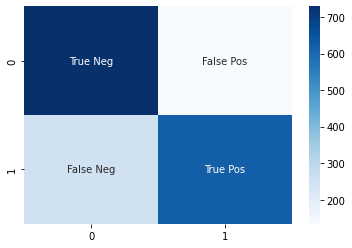

In [53]:
confusion_m = confusion_matrix(y_dev, y_pred)

labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_m, annot = labels, fmt = '', cmap = 'Blues');

Since we see, that many of the False entries are False Neg, we lower the cutoff.

In [54]:
iterations = 5000

logistic_regression = LogisticRegressionEstimator(learning_rate_ = 0.8, alpha_ = 1, iterations_ = iterations, cut_off_ = 0.1, verbose_ = True)
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_dev)
accuracy = accuracy_score(y_dev, y_pred)
accuracy

Iteration 0: Cost 1.03
Iteration 1000: Cost 0.45
Iteration 2000: Cost 0.43
Iteration 3000: Cost 0.42
Iteration 4000: Cost 0.41


0.7906843013225991

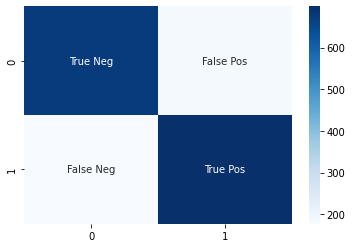

In [55]:
confusion_m = confusion_matrix(y_dev, y_pred)

labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_m, annot = labels, fmt = '', cmap = 'Blues');

# 🌠 Submission

<p>
    <img style="float:right; max-height:300px" src="https://upload.wikimedia.org/wikipedia/commons/d/d6/Gene_Wolfe%2C_2005.png">
</p>

<figure>
    <blockquote cite="https://www.amazon.com/Wizard-Book-Two-Knight/dp/0765350505">
        <p>"What a man knows hardly matters. It is what he does."</p>
    </blockquote>
    <figcaption>— Gene Wolfe, <cite>The Wizard (The Wizard Knight #2)</cite></figcaption>
</figure>

Image Source: <a href="https://en.wikipedia.org/wiki/Gene_Wolfe">Wikipedia</a>

In [56]:
X_test = df_test.to_numpy()

In [57]:
y_pred = logistic_regression.predict(X_test)

In [58]:
output = pd.DataFrame({'PassengerId': df_test_passengerId, 'Transported': y_pred})
output.to_csv('submission.csv', index = False)